In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar
import os

from matplotlib.legend_handler import HandlerErrorbar


In [2]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [3]:
data_loaded = pd.read_hdf('summary.h5')
data_loaded.shape


(14, 82127)

In [4]:
# Pull out the metrics we are interested in and define simple names

name_dict = {'FootprintFraction N year 1 u and night < 365 HealpixSlicer': 'Y1,u',
            'FootprintFraction N year 1 g and night < 365 HealpixSlicer': 'Y1,g',
            'FootprintFraction N year 1 r and night < 365 HealpixSlicer': 'Y1,r',

            'FootprintFraction N year 1 i and night < 365 HealpixSlicer': 'Y1,i',
    'best18k Parallax fiveSigmaDepth, filter, seeingFwhmGeom, ra_pi_amp, dec_pi_amp HealpixSlicer': 'parallax best 18k',
            'best18k properMotion HealpixSlicer': 'proper motion best 18k',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            #'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
            #'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe single model',
            #'Sum PrestoKNe_score_p UserPointsSlicer': 'KNe Score, P',
            'Sum ColorSlope visitExposureTime > 19 HealpixSlicer': 'color slope',
            "Sum ColorSlope2Night visitExposureTime > 19 HealpixSlicer": "2day\ncolor slope",
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances MBA 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'MBA',
            'CumulativeCompleteness H <= 18.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'Trojan',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances PHA 1 quad in 1 night detection loss MoObjSlicer': 'PHA, quad'}
            
# drop in the units for the columns
units = {'parallax best 18k': 'mas',
         'proper motion best 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe ZTF simple': 'N', 
         'KNe single model': 'N',
         'KNe Score, P': 'score',
         'XRB\nearly detect': 'N', 
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'MBA':'fraction',
         'Trojan': 'fraction',
         'Vatira': 'fraction',
         'PHA, quad': 'fraction',
         'Y1,u': '',
         'Y1,g': '',
         'Y1,r': '',
         'Y1,i': '',
         'color slope': 'N',
         '2day\ncolor slope': 'N',
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax best 18k', 'proper motion best 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira', 'MBA', 'Trojan',
           'u', 'g', 'r', 'i', 'z', 'y']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
            
           'Total detected KNePopMetric_DD:COSMOS_ztfrest_simple DD:COSMOS UserPointsSlicer': 'Kne COSMOS',
         'Total detected KNePopMetric_DD:ECDFS_ztfrest_simple DD:ECDFS UserPointsSlicer': 'Kne ECDFS',
 'Total detected KNePopMetric_DD:EDFS_ztfrest_simple DD:EDFS UserPointsSlicer': 'Kne EDFS',
 'Total detected KNePopMetric_DD:ELAISS1_ztfrest_simple DD:ELAISS1 UserPointsSlicer': 'Kne ELAISS1',
 'Total detected KNePopMetric_DD:WFD_ztfrest_simple DD:WFD UserPointsSlicer': 'Kne WFD',
 'Total detected KNePopMetric_DD:XMM_LSS_ztfrest_simple DD:XMM_LSS UserPointsSlicer': 'Kne XMM_LSS',
            
            'Median DD:COSMOS NVisits all bands HealpixSubsetSlicer':'N COSMOS',
 'Median DD:ECDFS NVisits all bands HealpixSubsetSlicer': 'N ECDFS',
 'Median DD:EDFS NVisits all bands HealpixSubsetSlicer': 'N EDFS',
 'Median DD:ELAISS1 NVisits all bands HealpixSubsetSlicer': 'N ELAISS1',
 'Median DD:WFD NVisits all bands HealpixSubsetSlicer': 'N WFD',
 'Median DD:XMM_LSS NVisits all bands HealpixSubsetSlicer': 'N XMM_LSS', 
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 
gaps_dict = {}
for filtername in 'ugrizy':
    for times in [3,7,24]:
        gaps_dict['Mean N gaps in %s at %ihr in top 18k Gaps_%ihr %s band HealpixSlicer'% (filtername, times, times, filtername)] = 'gaps %s %i' % (filtername, times)
        #gaps_dict['Mean Gaps_%ihr %s band HealpixSlicer' % (times, filtername)] = 'gaps %s %i' % (filtername, times)
        
gaps_data = pd.DataFrame()
for key in gaps_dict:
    gaps_data[gaps_dict[key]] = data_loaded[key]

In [5]:
data

,"Y1,u","Y1,g","Y1,r","Y1,i",parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N",...,2day\ncolor slope,XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira,"PHA, quad"
acord_v3.5_10yrs,0.988421,0.996294,0.996912,0.995429,0.744925,0.175652,0.3792,0.5139,805.0,140219.262843,...,1474108.0,2110.0,182668.119645,0.9474,0.659647,0.725311,0.930469,0.592055,0.4664,0.904803
baseline_v2.0_10yrs,0.955776,0.981594,0.994441,0.997035,0.791090,0.184088,0.3119,0.4348,839.0,99302.532220,...,1283741.0,1882.0,168080.497664,0.9294,0.642165,0.719712,0.919119,0.588234,0.0039,0.859388
baseline_v2.1_10yrs,0.948661,0.984188,0.996912,0.999012,0.806946,0.188258,0.3141,0.4319,838.0,99294.339899,...,1277085.0,1918.0,163809.598961,0.9286,0.647818,0.723396,0.927584,0.609144,0.0017,0.865595
baseline_v2.2_10yrs,0.871233,0.914268,0.993947,0.998023,0.792998,0.186345,0.3268,0.4487,830.0,112802.099640,...,1408541.0,1921.0,172447.199022,0.9304,0.657736,0.723964,0.933674,0.615614,0.0008,0.858646
baseline_v3.0_10yrs,0.813058,0.901174,0.993823,0.999135,0.792704,0.185683,0.3232,0.4528,795.0,109475.798536,...,1528234.0,1952.0,168026.998037,0.9326,0.642444,0.722371,0.924274,0.611475,0.0376,0.888025
baseline_v3.2_10yrs,0.973633,0.982335,0.996170,0.995800,0.782553,0.185369,0.3437,0.4869,805.0,123176.659086,...,1436743.0,2048.0,174046.841812,0.9460,0.642240,0.720853,0.926557,0.589189,0.4628,0.893770
baseline_v3.3_10yrs,0.987305,0.992712,0.997529,0.996294,0.753860,0.179042,0.3817,0.5233,811.0,152910.228661,...,1492778.0,2090.0,188214.630011,0.9442,0.659856,0.722551,0.942687,0.630071,0.4606,0.906586
baseline_v3.4_10yrs,0.981306,0.990364,0.995553,0.997529,0.752667,0.177617,0.3653,0.5179,817.0,151098.440513,...,1559032.0,2043.0,188718.767448,0.9478,0.667858,0.727785,0.943605,0.634531,0.4634,0.904225
ddf_agn_v3.5_10yrs,0.985491,0.993576,0.996294,0.996788,0.775709,0.182001,0.3699,0.5126,750.0,123006.852022,...,1325364.0,1999.0,176776.943362,0.9428,0.644473,0.723545,0.926512,0.600523,0.4625,0.902633
ddf_roll_deep_v3.5_10yrs,0.983817,0.991229,0.998147,0.997159,0.748114,0.176271,0.3805,0.5260,800.0,137875.495290,...,1446660.0,2078.0,182844.731981,0.9486,0.655351,0.723265,0.933231,0.603434,0.4682,0.905880


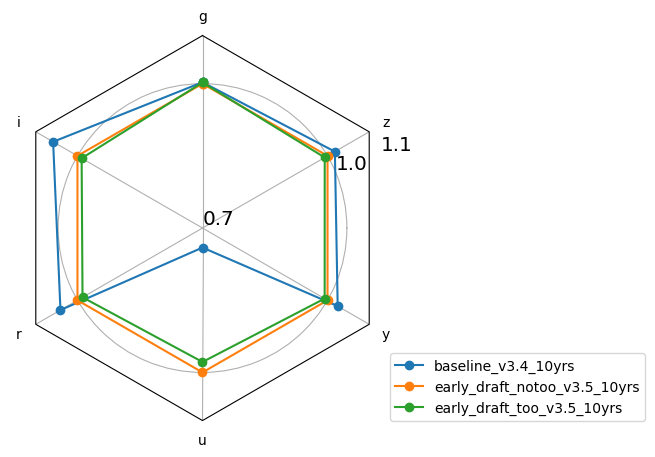

In [6]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'early' in run]
ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                 mag_cols = mag_cols, norm_run='early_draft_notoo_v3.5_10yrs')#, invert_cols=['u', 'g', 'r', 'i', 'z', 'y'])
fig, ax = radar(ndata, legend=True, rgrids=[0.7, 1.0, 1.1], bbox_to_anchor=(1.65, 0))


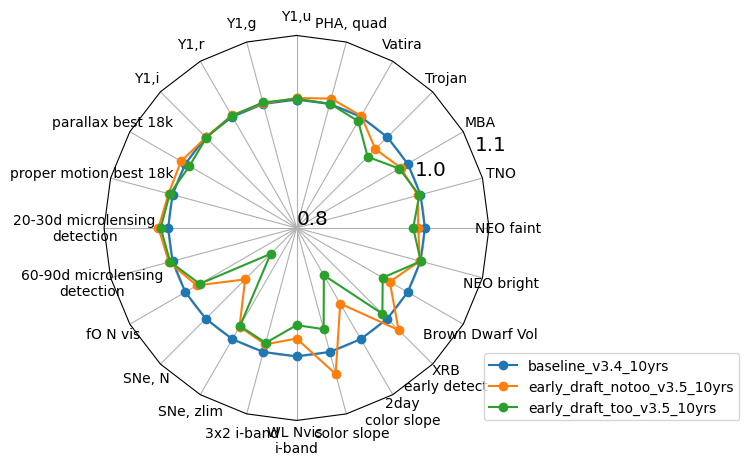

In [7]:
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.1], bbox_to_anchor=(1.65, 0))


In [8]:
data

,"Y1,u","Y1,g","Y1,r","Y1,i",parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N",...,2day\ncolor slope,XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira,"PHA, quad"
acord_v3.5_10yrs,0.988421,0.996294,0.996912,0.995429,0.744925,0.175652,0.3792,0.5139,805.0,140219.262843,...,1474108.0,2110.0,182668.119645,0.9474,0.659647,0.725311,0.930469,0.592055,0.4664,0.904803
baseline_v2.0_10yrs,0.955776,0.981594,0.994441,0.997035,0.791090,0.184088,0.3119,0.4348,839.0,99302.532220,...,1283741.0,1882.0,168080.497664,0.9294,0.642165,0.719712,0.919119,0.588234,0.0039,0.859388
baseline_v2.1_10yrs,0.948661,0.984188,0.996912,0.999012,0.806946,0.188258,0.3141,0.4319,838.0,99294.339899,...,1277085.0,1918.0,163809.598961,0.9286,0.647818,0.723396,0.927584,0.609144,0.0017,0.865595
baseline_v2.2_10yrs,0.871233,0.914268,0.993947,0.998023,0.792998,0.186345,0.3268,0.4487,830.0,112802.099640,...,1408541.0,1921.0,172447.199022,0.9304,0.657736,0.723964,0.933674,0.615614,0.0008,0.858646
baseline_v3.0_10yrs,0.813058,0.901174,0.993823,0.999135,0.792704,0.185683,0.3232,0.4528,795.0,109475.798536,...,1528234.0,1952.0,168026.998037,0.9326,0.642444,0.722371,0.924274,0.611475,0.0376,0.888025
baseline_v3.2_10yrs,0.973633,0.982335,0.996170,0.995800,0.782553,0.185369,0.3437,0.4869,805.0,123176.659086,...,1436743.0,2048.0,174046.841812,0.9460,0.642240,0.720853,0.926557,0.589189,0.4628,0.893770
baseline_v3.3_10yrs,0.987305,0.992712,0.997529,0.996294,0.753860,0.179042,0.3817,0.5233,811.0,152910.228661,...,1492778.0,2090.0,188214.630011,0.9442,0.659856,0.722551,0.942687,0.630071,0.4606,0.906586
baseline_v3.4_10yrs,0.981306,0.990364,0.995553,0.997529,0.752667,0.177617,0.3653,0.5179,817.0,151098.440513,...,1559032.0,2043.0,188718.767448,0.9478,0.667858,0.727785,0.943605,0.634531,0.4634,0.904225
ddf_agn_v3.5_10yrs,0.985491,0.993576,0.996294,0.996788,0.775709,0.182001,0.3699,0.5126,750.0,123006.852022,...,1325364.0,1999.0,176776.943362,0.9428,0.644473,0.723545,0.926512,0.600523,0.4625,0.902633
ddf_roll_deep_v3.5_10yrs,0.983817,0.991229,0.998147,0.997159,0.748114,0.176271,0.3805,0.5260,800.0,137875.495290,...,1446660.0,2078.0,182844.731981,0.9486,0.655351,0.723265,0.933231,0.603434,0.4682,0.905880


In [9]:
times = ['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
        'baseline_v3.0_10yrs',  'baseline_v3.2_10yrs', 'baseline_v3.3_10yrs', 'baseline_v3.4_10yrs', 
         'early_draft_notoo_v3.5_10yrs', 'early_draft_too_v3.5_10yrs']

sub_data = data.reindex(labels=times)
sub_ddf = ddf_data.reindex(labels=times)
sub_mag = mag_data.reindex(labels=times)
sub_gaps = gaps_data.reindex(labels=times)
sub_data



,"Y1,u","Y1,g","Y1,r","Y1,i",parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N",...,2day\ncolor slope,XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira,"PHA, quad"
retro_baseline_v2.0_10yrs,0.893276,0.949104,0.960964,0.958616,0.804364,0.176701,0.0878,0.1568,848.0,97124.012102,...,1072605.0,720.0,179634.826127,0.9048,0.624144,0.705922,0.943673,0.667514,0.0000,0.847855
baseline_v2.0_10yrs,0.955776,0.981594,0.994441,0.997035,0.791090,0.184088,0.3119,0.4348,839.0,99302.532220,...,1283741.0,1882.0,168080.497664,0.9294,0.642165,0.719712,0.919119,0.588234,0.0039,0.859388
baseline_v2.1_10yrs,0.948661,0.984188,0.996912,0.999012,0.806946,0.188258,0.3141,0.4319,838.0,99294.339899,...,1277085.0,1918.0,163809.598961,0.9286,0.647818,0.723396,0.927584,0.609144,0.0017,0.865595
baseline_v2.2_10yrs,0.871233,0.914268,0.993947,0.998023,0.792998,0.186345,0.3268,0.4487,830.0,112802.099640,...,1408541.0,1921.0,172447.199022,0.9304,0.657736,0.723964,0.933674,0.615614,0.0008,0.858646
baseline_v3.0_10yrs,0.813058,0.901174,0.993823,0.999135,0.792704,0.185683,0.3232,0.4528,795.0,109475.798536,...,1528234.0,1952.0,168026.998037,0.9326,0.642444,0.722371,0.924274,0.611475,0.0376,0.888025
baseline_v3.2_10yrs,0.973633,0.982335,0.996170,0.995800,0.782553,0.185369,0.3437,0.4869,805.0,123176.659086,...,1436743.0,2048.0,174046.841812,0.9460,0.642240,0.720853,0.926557,0.589189,0.4628,0.893770
baseline_v3.3_10yrs,0.987305,0.992712,0.997529,0.996294,0.753860,0.179042,0.3817,0.5233,811.0,152910.228661,...,1492778.0,2090.0,188214.630011,0.9442,0.659856,0.722551,0.942687,0.630071,0.4606,0.906586
baseline_v3.4_10yrs,0.981306,0.990364,0.995553,0.997529,0.752667,0.177617,0.3653,0.5179,817.0,151098.440513,...,1559032.0,2043.0,188718.767448,0.9478,0.667858,0.727785,0.943605,0.634531,0.4634,0.904225
early_draft_notoo_v3.5_10yrs,0.983817,0.991229,0.998147,0.997159,0.746776,0.176472,0.3805,0.5239,800.0,138000.957293,...,1459521.0,2094.0,182640.178393,0.9468,0.657437,0.723859,0.931016,0.608349,0.4650,0.912080
early_draft_too_v3.5_10yrs,0.982422,0.992835,0.997282,0.996418,0.758170,0.176810,0.3770,0.5218,796.0,129501.771283,...,1379940.0,2021.0,180231.559491,0.9482,0.649704,0.725811,0.928515,0.591284,0.4556,0.904685


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_71436/3763499284.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',


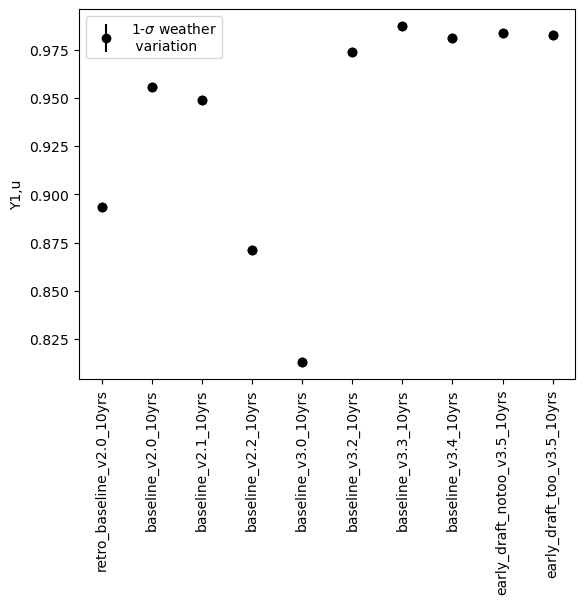

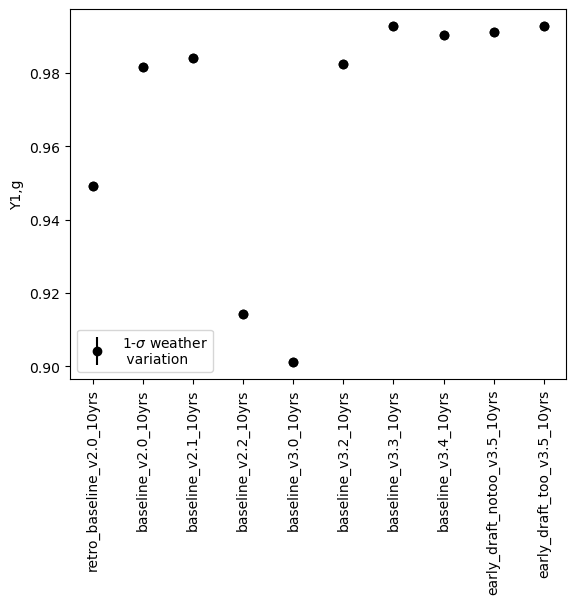

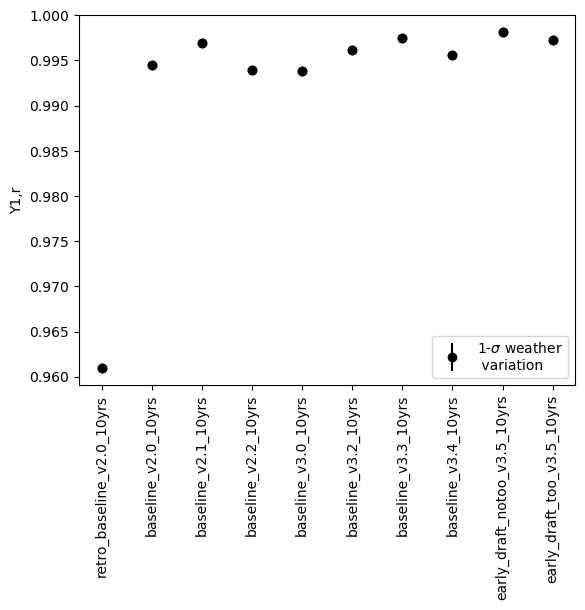

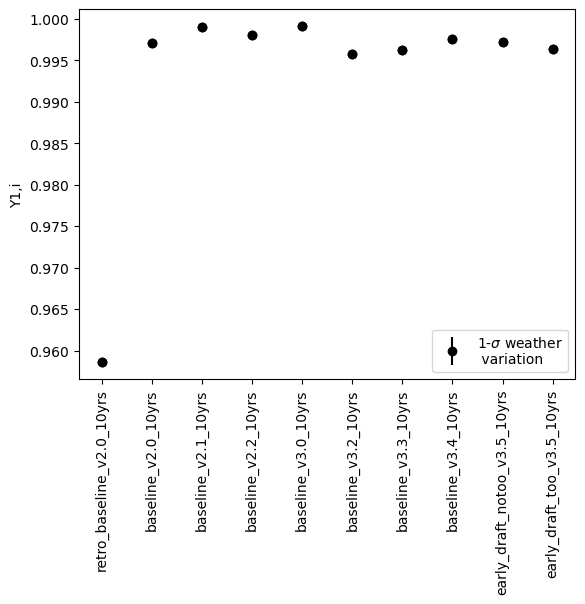

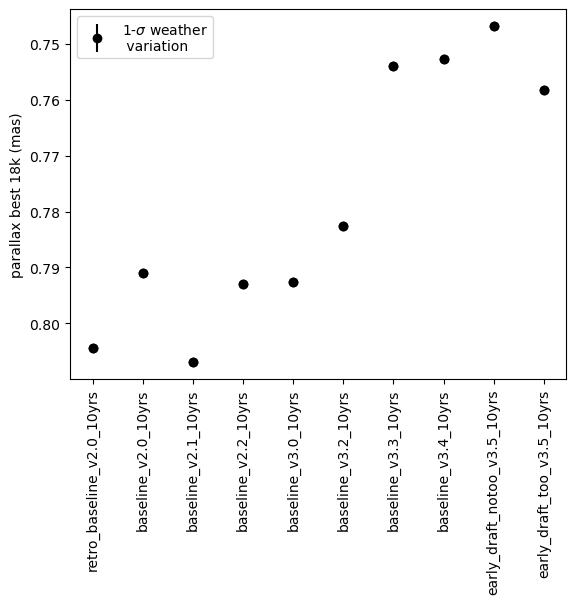

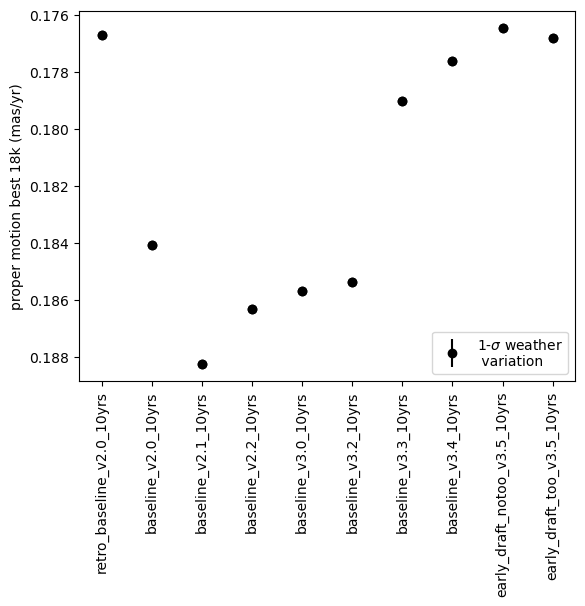

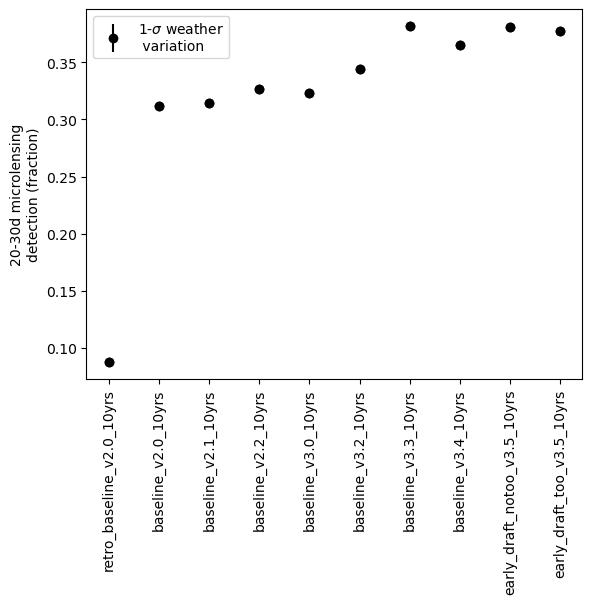

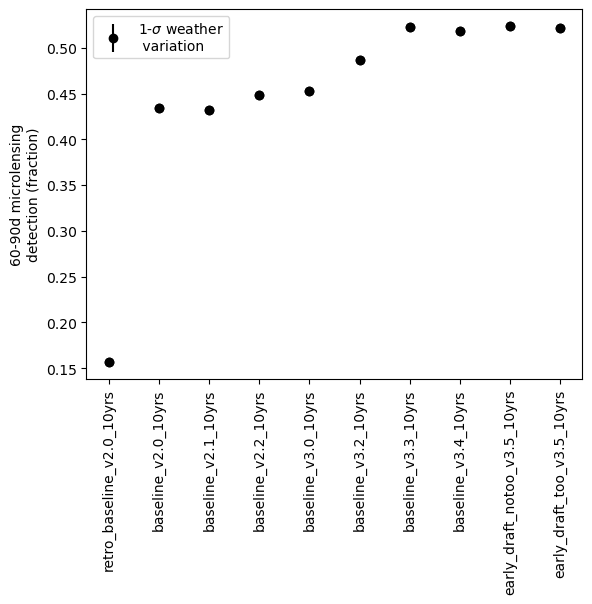

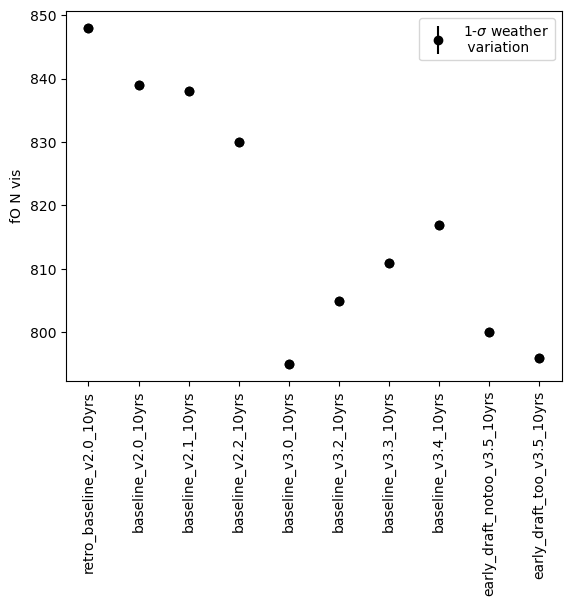

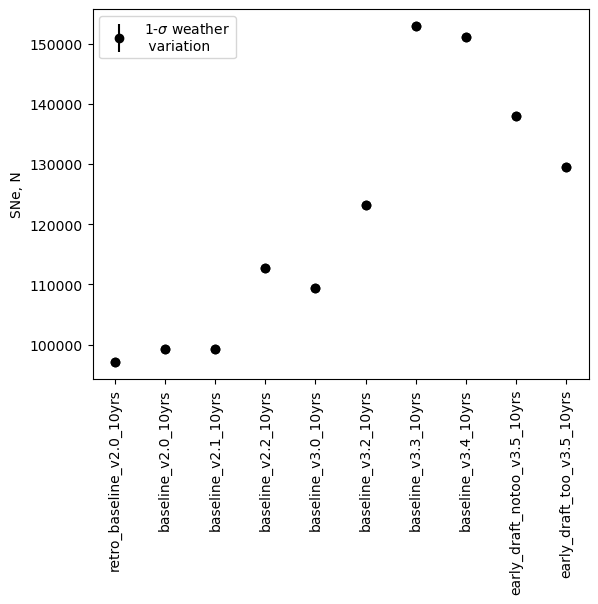

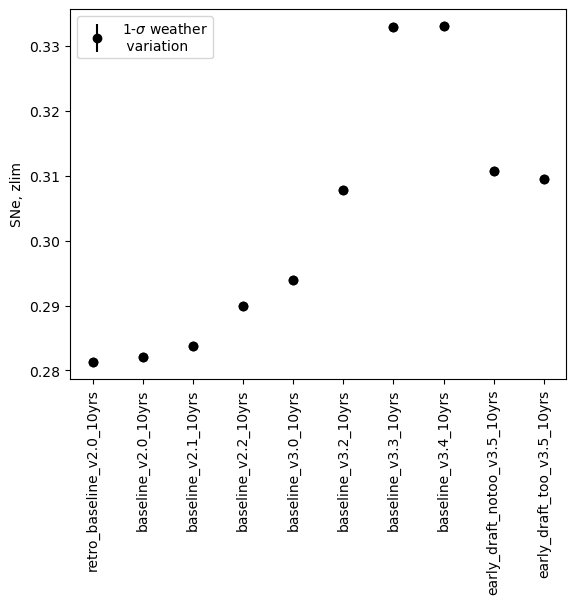

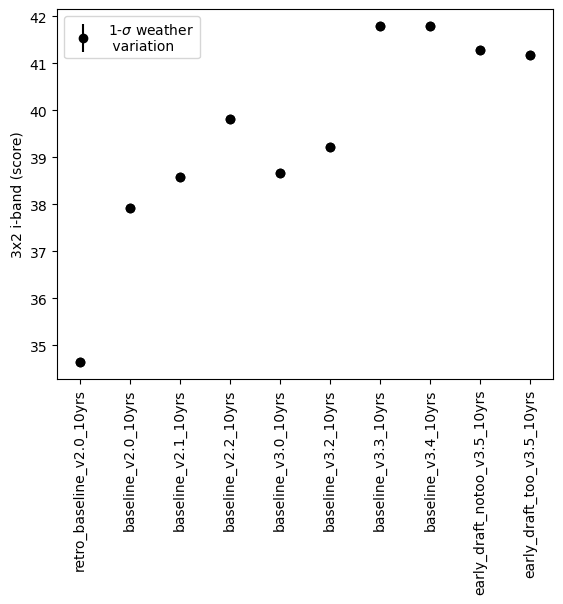

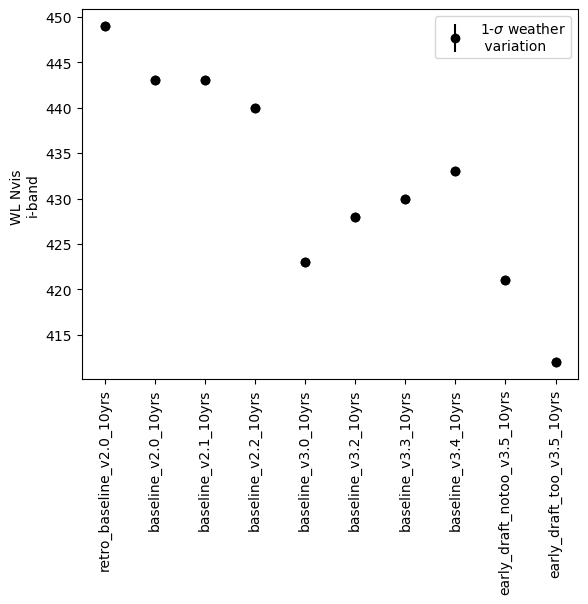

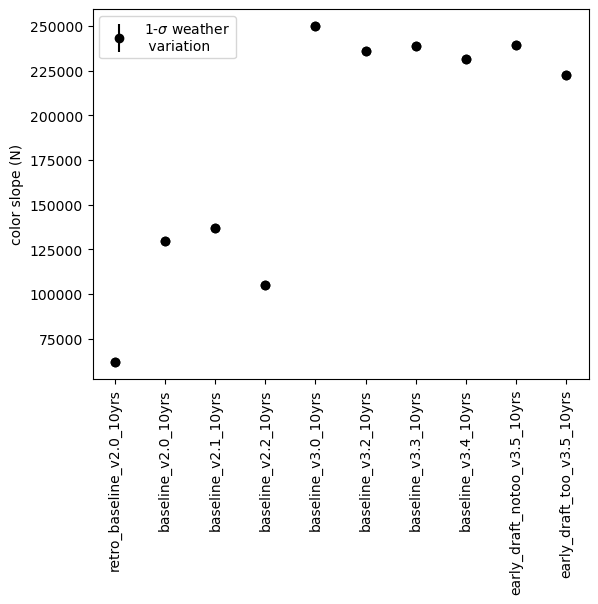

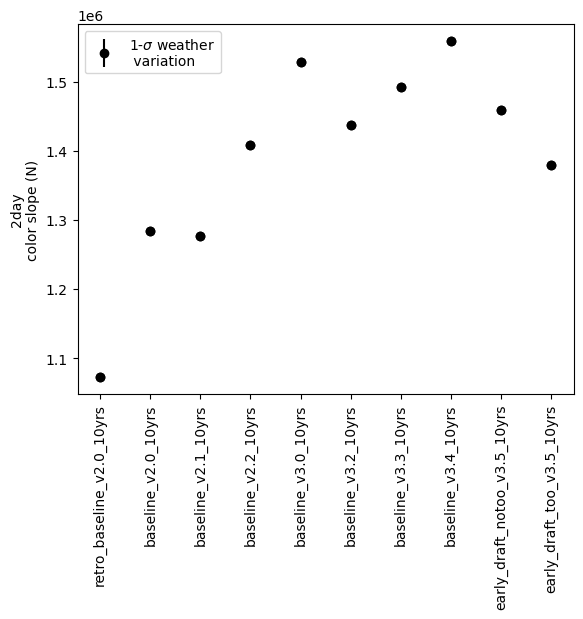

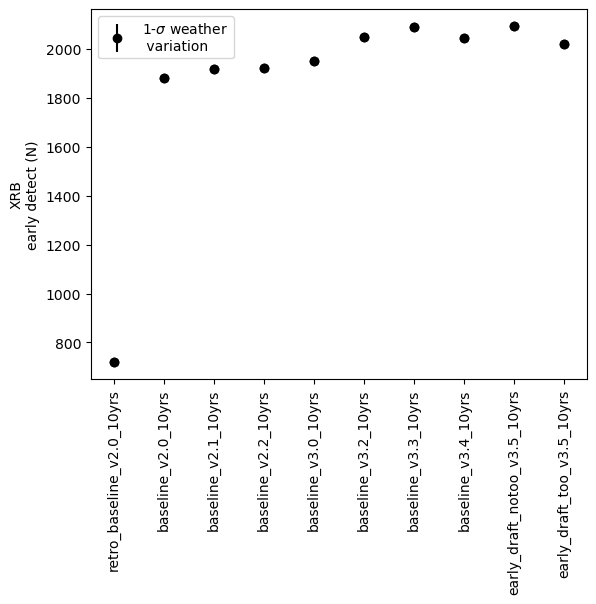

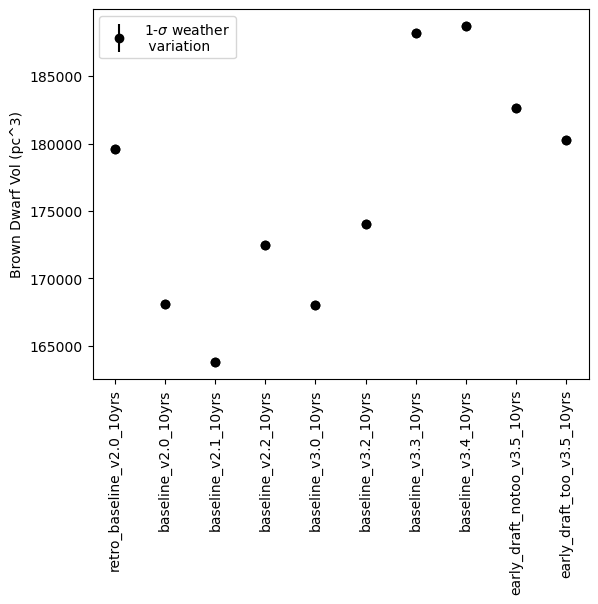

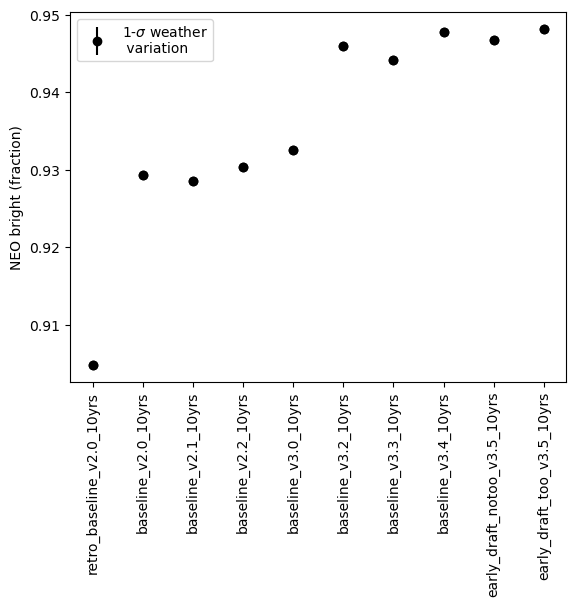

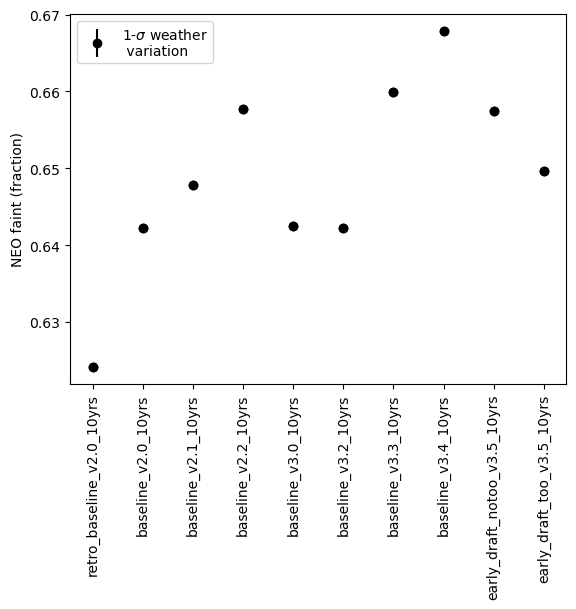

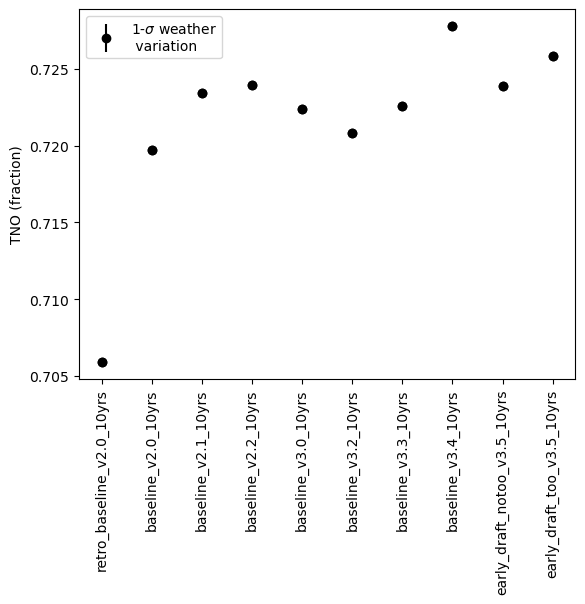

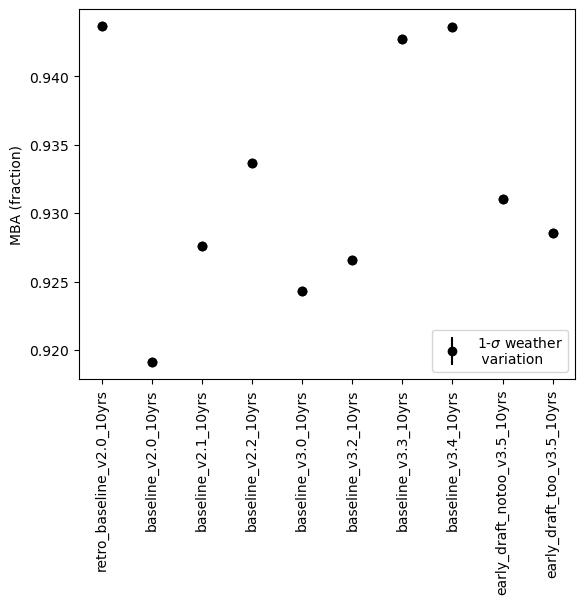

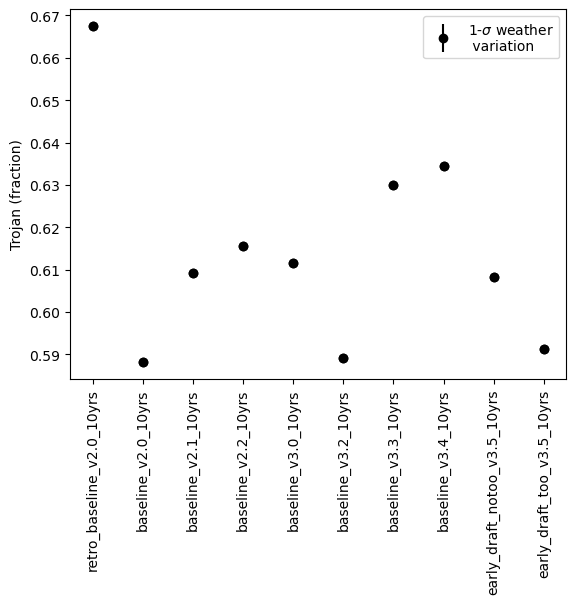

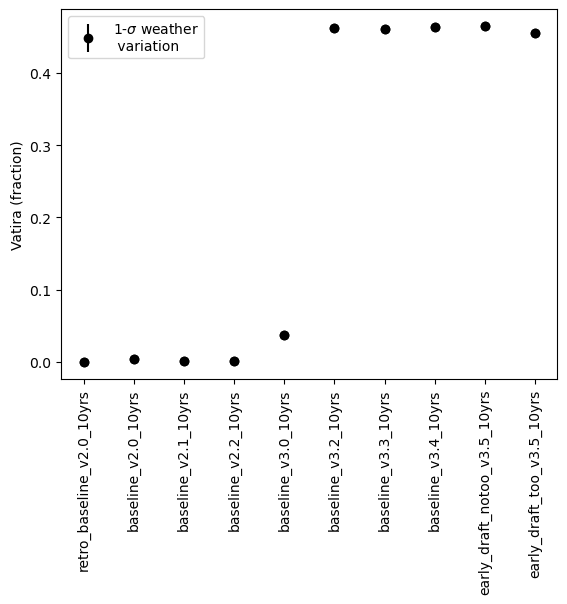

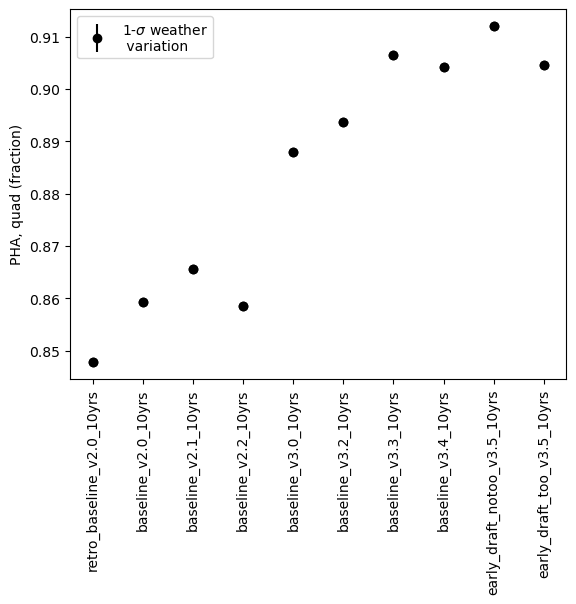

In [10]:
# Rough error bars from weather simulations
std_dict = {}
weather_runs = [run for run in data.index if 'weather' in run]
for col in data.columns:
    std_dict[col] = np.std(data.loc[weather_runs][col])

std_mag_dict = {}
for col in mag_data.columns:
    std_mag_dict[col] = np.std(mag_data.loc[weather_runs][col])
    
std_ddf_dict = {}
for col in ddf_data.columns:
    std_ddf_dict[col] = np.std(ddf_data.loc[weather_runs][col])
 

std_gaps_dict = {}
for col in gaps_data.columns:
    std_gaps_dict[col] = np.std(gaps_data.loc[weather_runs][col])


#col = data.columns[0]
for col in sub_data.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    if units[col] != '':
        label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])
